In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from pathlib import Path
from tqdm import tqdm

from data_loader_pytorch import DataGenerator
from models_pytorch import VAEmodel, LSTMModel
from trainers_pytorch import VAETrainer
from utils import process_config, create_dirs

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # keep GPU ordering consistent
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
# load VAE model
config = process_config('config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir'], config['checkpoint_dir_lstm']])
# create your data generator
data = DataGenerator(config)

In [5]:
# create a VAE model and load the latest checkpoint
vae_model = VAEmodel(config).to(device)
vae_model.eval()
vae_trainer = VAETrainer(vae_model, data, config)

checkpoint_dir = config['checkpoint_dir']
checkpoint_files = [f for f in Path(checkpoint_dir).iterdir() if f.name.startswith('vae_checkpoint') and f.name.endswith('.pth')]
if not checkpoint_files:
    raise FileNotFoundError(f"No VAE checkpoint found in {checkpoint_dir}")
latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))
vae_trainer.load_model(latest_checkpoint)
vae_model.eval()


Model loaded from experiments/local-results/WESAD/batch-32/WESAD-48-12-6-fixedSigma-0.1/checkpoint/vae_checkpoint_epoch_10.pth


VAEmodel(
  (enc_conv1): Conv2d(67, 32, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv4): Conv2d(128, 512, kernel_size=(6, 1), stride=(1, 1))
  (enc_fc): Linear(in_features=512, out_features=24, bias=True)
  (enc_fc_mean): Linear(in_features=24, out_features=6, bias=True)
  (enc_fc_std): Linear(in_features=24, out_features=6, bias=True)
  (dec_fc): Linear(in_features=6, out_features=512, bias=True)
  (dec_conv1): Conv2d(512, 768, kernel_size=(1, 1), stride=(1, 1))
  (dec_conv2): Conv2d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv3): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv4): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_out): Conv2d(16, 67, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
)

In [6]:
# load LSTM model
lstm_model = LSTMModel(config).to(device)
lstm_checkpoint_path = Path(config['checkpoint_dir_lstm']) / 'lstm_model.pth'
if not lstm_checkpoint_path.is_file():
    raise FileNotFoundError(f"Expected LSTM checkpoint at {lstm_checkpoint_path}")
lstm_state_dict = torch.load(lstm_checkpoint_path, map_location=device)
lstm_model.load_state_dict(lstm_state_dict)
lstm_model.eval()
print(f"Loaded LSTM checkpoint: {lstm_checkpoint_path.name}")

Loaded LSTM checkpoint: lstm_model.pth


In [7]:
# load normalised time series
data_dir = Path('../data/')

train_df = pd.read_csv(data_dir / 'train.csv')
train_df = train_df.drop(columns=['label', 'subject_id'])
train_m = train_df.mean()
train_std = train_df.std()

# train_df_with_anomaly = pd.read_csv(data_dir / 'train_with_anomaly.csv')
# train_df_subjects_with_anomaly = train_df_with_anomaly.pop('subject_id')
# train_df_labels_with_anomaly = train_df_with_anomaly.pop('label')

test_df = pd.read_csv(data_dir / 'test.csv')
test_subjects = test_df.pop('subject_id')
test_label = test_df.pop('label')
test_df_normalized = (test_df - train_m) / train_std

result = {}
result['test'] = test_df_normalized.to_numpy()
result['idx_anomaly_test'] = test_label[test_label == 1].index.to_numpy()
result['train_m'] = train_m.values[0]
result['train_std'] = train_std.values[0]
result['t_unit'] = '0.25 sec'
result['t_test'] = np.arange(len(test_df_normalized))

test_windows, test_seq = data.test_set_vae['data'], data.test_set_lstm['data']
print(test_windows.shape)
print(test_seq.shape)

(44497, 48, 67)
(41857, 12, 48, 67)


In [8]:

# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    window_tensor = torch.from_numpy(test_win).float().unsqueeze(0).to(device)
    with torch.no_grad():
        recon_win, latent_mean, latent_std = vae_model(window_tensor)
    recon_win = recon_win.squeeze(0).cpu().numpy()
    latent_mean = latent_mean.squeeze(0).cpu().numpy()
    latent_std = latent_std.squeeze(0).cpu().numpy()

    test_vae_recons_error = np.sum(np.square(recon_win - test_win))
    safe_std = np.clip(latent_std, 1e-9, None)
    test_vae_kl = 0.5 * (
        np.sum(np.square(latent_mean))
        + np.sum(np.square(safe_std))
        - np.sum(np.log(np.square(safe_std)))
        - config['code_size']
    )

    sigma2 = vae_model.get_sigma2().item()
    input_dims = vae_model.input_dims
    sigma_regularisor = input_dims / 2.0 * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error / sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo


def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    seq_tensor = torch.from_numpy(test_seq).float().to(device)
    seq_tensor = seq_tensor.view(config['l_seq'], config['l_win'], config['n_channel'])

    with torch.no_grad():
        vae_mean, _ = vae_model.encode(seq_tensor)
        input_embeddings = vae_mean[:-1].unsqueeze(0)
        lstm_pred = lstm_model(input_embeddings).squeeze(0)
        embedding_error = torch.sum((vae_mean[1:] - lstm_pred) ** 2).item()

        reconstructed = vae_model.decode(lstm_pred)
        reconstructed = reconstructed.squeeze(-1)
        target_windows = seq_tensor[1:].squeeze(-1)
        reconstruction_error = torch.sum((reconstructed - target_windows) ** 2).item()

    return reconstruction_error, embedding_error

n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in tqdm(range(n_val_vae)):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in tqdm(range(n_val_lstm)):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])


100%|██████████| 5595/5595 [00:11<00:00, 507.16it/s]


In [9]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

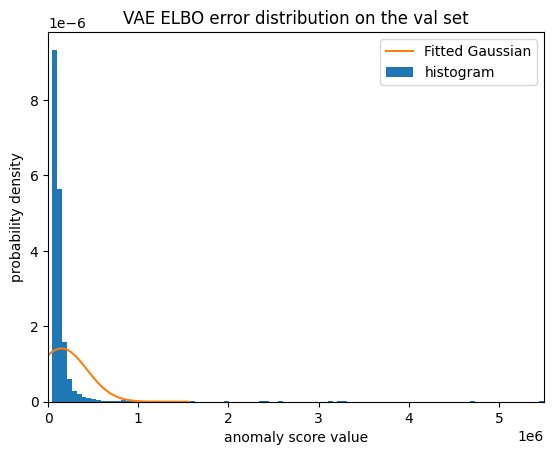

25% percentile: 76073.87733494099
75% percentile: 132530.377334941
These windows scored the top 1% of anomaly metric (1049726.93592869): 
[ 420  421  422  996  997  998  999 1000 1001 1002 1229 1230 1231 1232
 1233 1379 1380 1381 1382 1669 1670 1671 1672 1673 1674 1811 1812 2244
 2245 2246 2247 2248 2249 2250 2251 2252 3027 3028 3029 3041 3042 3043
 3044 3045 3046 3047 3189 3190 3191 3550 3551 3552 3553 3554 3555 3615
 3616 3617 4320 5842 5843 5844]


In [10]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

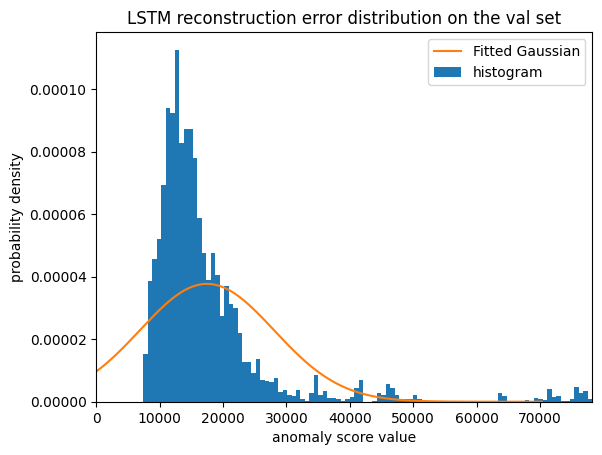

25% percentile: 11958.0146484375
75% percentile: 18947.388671875
These windows scored the top 1% of anomaly metric (72740.00546875002): 
[ 302  313  323 1164 1174 1189 1190 1206 1207 1216 1226 1233 1234 1254
 1262 1286 1287 1310 1355 1363 1371 1372 1388 1389 1390 1402 1419 1427
 1428 1440 1441 1456 1457 1474 1486 1487 1496 1510 1524 1537 1553 1569
 1570 1596 1597 1603 1604 1619 1633 1634 1652 1653 1674 1689 1702 1703]


In [11]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [12]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in tqdm(range(n_test_lstm)):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

100%|██████████| 41857/41857 [01:24<00:00, 494.61it/s]

All windows' reconstruction error is computed.
The total number of windows is 41857


25% percentile: 24525.27734375
75% percentile: 59674.06640625
These windows scored the top 1% of anomaly metric (338956.23250000004): 
[ 130  131  159  163  164  165  166  167  303  304  305  337  338  339
  340  341  477  478  479  507  511  512  513  514  515  651  652  653
  685  686  687  688  689  825  826  827  859  860  861  862  863  999
 1000 1001 1033 1034 1035 1036 1037 1173 1174 1175 1207 1208 1209 1210
 1211 1347 1348 1349 1381 1382 1383 1384 1385 1521 1522 1523 1555 1556
 1557 1558 1559 1695 1696 1697 1729 1730 1731 1732 1733 1869 1870 1871
 1899 1903 1904 1905 1906 1907 2043 2044 2045 2073 2077 2078 2079 2080
 2081 2217 2218 2219 2247 2251 2252 2253 2254 2255 2391 2392 2393 2421
 2425 2426 2427 2428 2429 2565 2566 2567 2595 2599 2600 2601 2602 2603
 2739 2740 2741 2769 2773 2774 2775 2776 2777 2913 2914 2915 2943 2947
 2948 2949 2950 2951 3087 3088 3089 3091 3117 3121 3122 3123 3124 3125
 3261 3262 3263 3265 3291 3295 3296 3297 3298 3299 3435 3436 3437 3439
 3465 3469 34

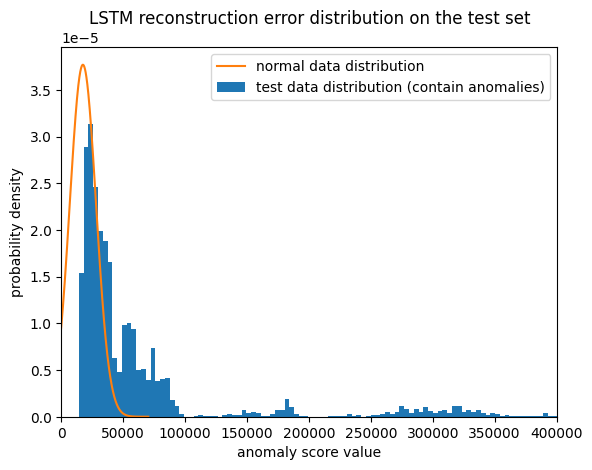

In [13]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None, saveplot=True)

In [17]:
idx_anomaly_test = result['idx_anomaly_test']
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in tqdm(range(len(idx_anomaly_test))):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

100%|██████████| 13684/13684 [00:00<00:00, 318631.96it/s]

(41857,)


In [18]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    idx_error = np.flatnonzero(test_anomaly_metric > threshold)
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    return idx_error

In [19]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    idx_detected_anomaly_set = set(idx_detected_anomaly)
    idx_detected_anomaly_extended = set(idx_detected_anomaly)
    
    # anomaly_index는 이상 구간(리스트의 리스트)이라고 가정
    for anomaly_win in anomaly_index:
        # 현재 이상 구간(anomaly_win)이 기존 탐지에 포함되었는지 확인
        # set intersection이 빠름
        if idx_detected_anomaly_set.intersection(anomaly_win):
            # 포함되었다면 해당 구간 전체를 확장된 set에 추가
            idx_detected_anomaly_extended.update(anomaly_win)

    # numpy로 변환 후 정렬
    return np.sort(np.array(list(idx_detected_anomaly_extended), dtype=int))

In [20]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):  
    detected_labels = test_labels[idx_detected_anomaly]
    n_TP = np.sum(detected_labels == 1)
    n_FP = np.sum(detected_labels == 0)
    n_FN = np.sum(test_labels == 1) - n_TP
    
    return n_TP, n_FP, n_FN

In [21]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    precision = n_TP / (n_TP + n_FP) if (n_TP + n_FP) > 0 else 1.0
    recall = n_TP / (n_TP + n_FN) if (n_TP + n_FN) > 0 else 0.0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [23]:
# Now select a threshold
threshold = np.percentile(val_lstm_recons_error, 100)

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 78250.0390625

PR evaluation using augmented detection:
Precision: 0.7561474277504558
Recall: 1.0
F1: 0.861143450489286
TP: 13684
FP: 4413
FN: 0


In [26]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [27]:
def plot_detected_anomalies(idx_detection, interval, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test[:, 0]) # plot only the first channel
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title(f"dataset test sequence\n(normalised by train mean {result['train_m']:.4f} and std {result['train_std']:.4f})\n Detection method: {detection_method}")
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 2 sequences


/tmp/ipykernel_98257/3962814121.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/tmp/ipykernel_98257/3962814121.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/home/peunsu/ml_project/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


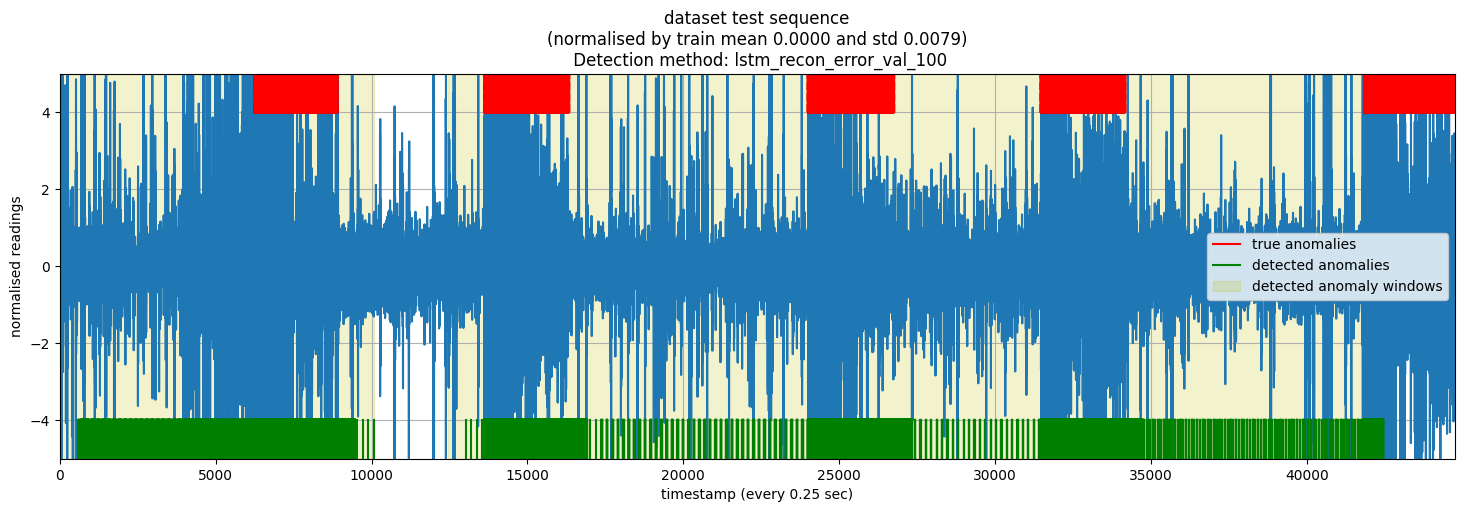

In [33]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2,
                        result=result, 
                        detection_method='lstm_recon_error_val_100',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)

In [29]:
percentile_list = np.arange(0, 100.1, 1)
threshold_list = np.percentile(test_lstm_recons_error, percentile_list)

n_threshold = len(threshold_list)

precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)

precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)

for i, threshold in tqdm(enumerate(threshold_list)):
    #print(threshold_list[i])
    idx_detection_vae = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_vae, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_vae_augmented = augment_detected_idx(idx_detection_vae, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_vae_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)

101it [00:42,  2.37it/s]


In [30]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision) / n_threshold
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug) / n_threshold
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.4968254557605911
Best threshold is 17381.025078125
At this threshold, precision is 0.333009805385496, recall is 0.9778573516515638
Average precision is -0.33108609996416144

Augmented detection:
Best F1 score is 0.8780519105521513
Best threshold is 83751.44437500002
At this threshold, precision is 0.7826136688590221, recall is 1.0
Average precision is -0.7585637185622575


In [31]:
# Now select a threshold
threshold = 83751

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 83751

PR evaluation using augmented detection:
Precision: 0.7826136688590221
Recall: 1.0
F1: 0.8780519105521513
TP: 13684
FP: 3801
FN: 0


Detected 2 sequences


/tmp/ipykernel_98257/3962814121.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/tmp/ipykernel_98257/3962814121.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/home/peunsu/ml_project/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


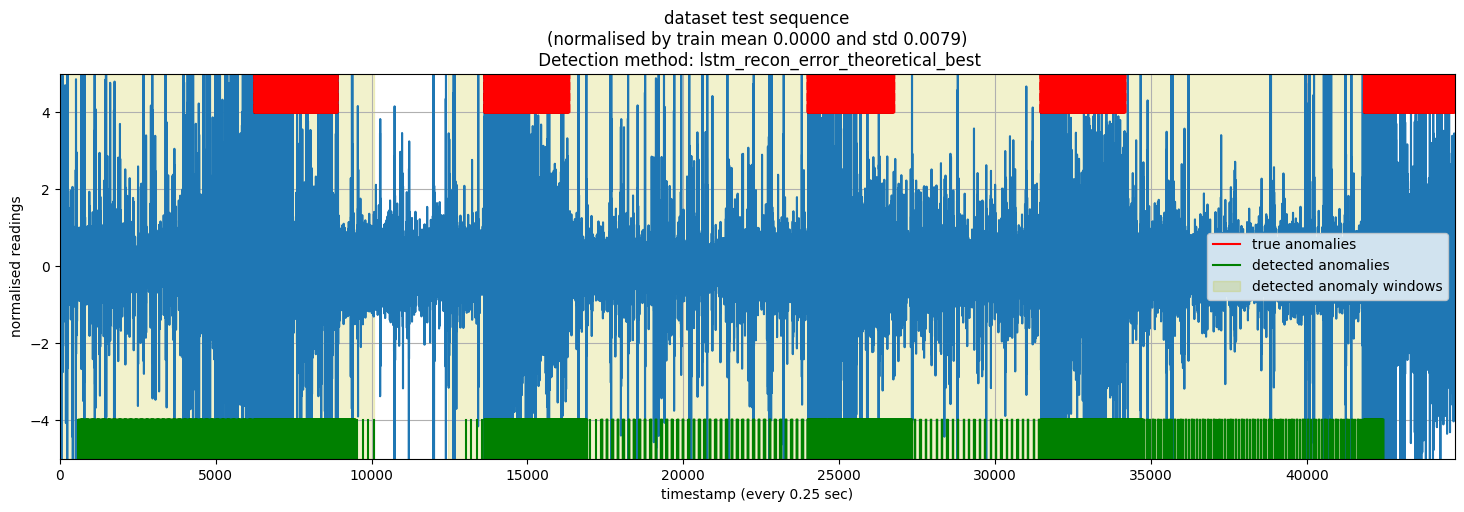

In [32]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2,
                        result=result, 
                        detection_method='lstm_recon_error_theoretical_best',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)